In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder 
from sklearn import preprocessing
from tensorflow import keras
from tensorflow.keras import layers

pd.set_option('display.max_rows', 500)

In [2]:
# Cleaning Data

df = pd.read_csv('data/stock_XY_train.csv')
print('OG Data Size:{}'.format(df.shape))


dropped_columns = (df[df.columns[df.isnull().mean() > 0.15]].columns)
df = df[df.columns[df.isnull().mean() < 0.15]] # TO-DO: Tinker around with mean threshold.
df = df.dropna()
print('New Data Size:{}'.format(df.shape))
del df['operatingProfitMargin'] # Got rid of this column because it is all `1`. No reason to keep.

del df['Ticker']
del df['Sector']
del df['Yr']

OG Data Size:(12379, 226)
New Data Size:(8977, 156)


In [3]:
# Separating to train and test data
train_df = df.sample(frac=0.8,random_state=0)
test_df = df.drop(train_df.index)

# Grabbing stats in order to normalize data
train_stats = train_df.describe()
train_stats.pop('Buy')
train_stats = train_stats.transpose()

# Separating labels
train_label = train_df.pop('Buy')
test_label = test_df.pop('Buy')

# Normalizing Data
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_df)
normed_test_data = norm(test_df)

In [4]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_df.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    optimizer = tf.keras.optimizers.Adam(
                    learning_rate=0.001, 
                    beta_1=0.9, 
                    beta_2=0.999, 
                    epsilon=1e-07, 
                    amsgrad=False,
                    decay=0.001,
                    name='Adam')

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse', 'accuracy'])
    return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                9728      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 13,953
Trainable params: 13,953
Non-trainable params: 0
_________________________________________________________________


In [5]:
EPOCHS = 200
BATCH_SIZE = 32

history = model.fit(
    normed_train_data, 
    train_label,
    epochs=EPOCHS, 
    validation_split=0.2, 
    verbose=0,
    batch_size=BATCH_SIZE)

In [6]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,mae,mse,accuracy,val_loss,val_mae,val_mse,val_accuracy,epoch
0,0.248926,0.484633,0.248926,0.578938,0.238818,0.473837,0.238818,0.615170,0
1,0.232531,0.463961,0.232531,0.625587,0.232177,0.463137,0.232177,0.620738,1
2,0.223358,0.449302,0.223358,0.648564,0.230602,0.459772,0.230602,0.640223,2
3,0.219016,0.441878,0.219016,0.657615,0.223859,0.450028,0.223859,0.652749,3
4,0.212769,0.432391,0.212769,0.676240,0.219298,0.441366,0.219298,0.664579,4
5,0.209364,0.425374,0.209364,0.684247,0.219496,0.436755,0.219496,0.659708,5
6,0.205921,0.418938,0.205921,0.691906,0.217674,0.433328,0.217674,0.666667,6
7,0.202787,0.414327,0.202787,0.698869,0.217002,0.430772,0.217002,0.665971,7
8,0.200930,0.411470,0.200930,0.704613,0.217085,0.428272,0.217085,0.663883,8
9,0.198477,0.406354,0.198477,0.704265,0.217221,0.428888,0.217221,0.673626,9


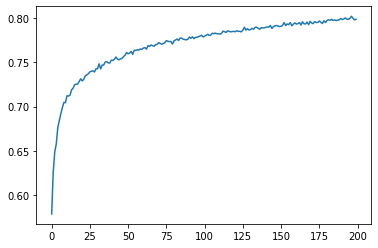

In [7]:
# plt.plot(hist['epoch'], hist['loss'])
plt.plot(hist['epoch'], hist['accuracy'])

In [8]:
model.fit(normed_train_data, train_label, epochs=200)

Train on 7182 samples
Epoch 1/200
7182/7182 [==============================] - 0s 38us/sample - loss: 0.1615 - mae: 0.3359 - mse: 0.1615 - accuracy: 0.7729
Epoch 2/200
7182/7182 [==============================] - 0s 32us/sample - loss: 0.1611 - mae: 0.3357 - mse: 0.1611 - accuracy: 0.7708
Epoch 3/200
7182/7182 [==============================] - 0s 33us/sample - loss: 0.1607 - mae: 0.3350 - mse: 0.1607 - accuracy: 0.7721
Epoch 4/200
7182/7182 [==============================] - 0s 34us/sample - loss: 0.1605 - mae: 0.3348 - mse: 0.1605 - accuracy: 0.7726
Epoch 5/200
7182/7182 [==============================] - 0s 39us/sample - loss: 0.1602 - mae: 0.3345 - mse: 0.1602 - accuracy: 0.7728
Epoch 6/200
7182/7182 [==============================] - 0s 34us/sample - loss: 0.1601 - mae: 0.3348 - mse: 0.1601 - accuracy: 0.7739
Epoch 7/200
7182/7182 [==============================] - 0s 41us/sample - loss: 0.1600 - mae: 0.3340 - mse: 0.1600 - accuracy: 0.7757
Epoch 8/200
7182/7182 [=================

7182/7182 [==============================] - 0s 35us/sample - loss: 0.1502 - mae: 0.3221 - mse: 0.1502 - accuracy: 0.7916
Epoch 122/200
7182/7182 [==============================] - 0s 32us/sample - loss: 0.1501 - mae: 0.3220 - mse: 0.1501 - accuracy: 0.7925
Epoch 123/200
7182/7182 [==============================] - 0s 33us/sample - loss: 0.1501 - mae: 0.3216 - mse: 0.1501 - accuracy: 0.7914
Epoch 124/200
7182/7182 [==============================] - 0s 32us/sample - loss: 0.1501 - mae: 0.3218 - mse: 0.1501 - accuracy: 0.7931
Epoch 125/200
7182/7182 [==============================] - 0s 32us/sample - loss: 0.1500 - mae: 0.3217 - mse: 0.1500 - accuracy: 0.7928
Epoch 126/200
7182/7182 [==============================] - 0s 42us/sample - loss: 0.1500 - mae: 0.3216 - mse: 0.1500 - accuracy: 0.7920
Epoch 127/200
7182/7182 [==============================] - 0s 33us/sample - loss: 0.1499 - mae: 0.3215 - mse: 0.1499 - accuracy: 0.7935
Epoch 128/200
7182/7182 [==============================] - 0s 

In [9]:
results = model.evaluate(normed_test_data, test_label, batch_size=128)
print('test loss, test acc:', results)

1795/1795 [==============================] - 0s 6us/sample - loss: 0.2450 - mae: 0.4160 - mse: 0.2450 - accuracy: 0.6267
test loss, test acc: [0.2450499008458969, 0.41596347, 0.2450499, 0.62674093]


# Submission File Generation

In [10]:
dfTest = pd.read_csv('data/stock_X_test.csv').drop('Unnamed: 0', axis=1).rename({'Unnamed: 0.1': 'Unnamed: 0'}, axis='columns')

dfTest = dfTest.drop(dropped_columns, axis=1) # TO-DO: Tinker around with mean threshold.
del dfTest['operatingProfitMargin'] # Got rid of this column because it is all `1`. No reason to keep.

del dfTest['Ticker']
del dfTest['Sector']
del dfTest['Yr']

dfTest['Buy'] = [1 if x else 0 for x in model.predict(dfTest) > 0]
dfTest[['Unnamed: 0', 'Buy']].to_csv('submission.csv', index=None, header=True)

/home/tiffany/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
